# Basic usage of `qbiome`

First, load package and some other helper packages for the analysis:

In [1]:
import qbiome
from qbiome.data_formatter import DataFormatter
from qbiome.quantizer import Quantizer
from qbiome.qnet_orchestrator import QnetOrchestrator
from qbiome.forecaster import Forecaster
from qbiome.hypothesis import Hypothesis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
plt.style.use("ggplot")

from qbiome.qutil import qsmooth

Next, we load the data. 

For this example, we use a dataset from Bokulich et. al 

- [Antibiotics, birth mode, and diet shape microbiome maturation during early life](https://doi.org/10.1126/scitranslmed.aad7121) 

The `qbiome` package includes helper methods for processing data into the correct format for Qnet construction, using the `DataFormatter()` below. If your source data is formatted differently, you may need to write your own preprocessing steps.

In [2]:
dirname = "example_data/"
data = (
    dirname + "SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_TaxaRelativeAbundance.csv"
)
meta = dirname + "SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_Characteristics.csv"
base_tax = "Order"

formatter = DataFormatter()
data = formatter.load_data(
    fpath_data=data, fpath_meta=meta, taxon_name=base_tax, tax_dict={}
)

There are 123 unique biomes and 1216 unique samples
There are 311 unique days
There are 99 unique weeks


Qnet construction requires the numeric data to be quantized into categorical data. Given abundance data in long-format (eg. produced by the above formatting), the `qbiome` package can quantize the data.

Data should be in the following format:

In [3]:
data

,sample_id,subject_id,variable,week,value
30,MBSMPL0020-6-10,1,unclassified_Bacteria,27,0.003478
31,MBSMPL0020-6-10,1,Bacteroidales,27,0.507248
32,MBSMPL0020-6-10,1,Bifidobacteriales,27,0.366650
33,MBSMPL0020-6-10,1,unclassified_Bacteria,27,0.002032
34,MBSMPL0020-6-10,1,Clostridiales,27,0.000587
...,...,...,...,...,...
19500,MBSMPL0020-6-998,16,unclassified_Bacteria,7,0.143349
19501,MBSMPL0020-6-998,16,Lachnospirales,7,0.005815
19502,MBSMPL0020-6-998,16,Lactobacillales,7,0.136510
19503,MBSMPL0020-6-998,16,Peptostreptococcales-Tissierellales,7,0.149381


Then we may use `Quantizer()` methods to process the data into the correct format for fitting the qnet.

By default, the `Quantizer()` quantizes the range of each variable into 5 levels; this can be modified by setting the `num_levels` parameter. The ordered levels are given categorical labels corresponding to the letters of the English alphabet, i.e. `A` corresponds to the lowest level of a given variable, `B` corresponds to the next lowest level, etc.

The optimal precision level for the quantization is a function of the data available for a given problem: for some problems, using higher values for `num_levels` will improve performance, but this does not seem to always be the case.

In [4]:
# select a biome to test/visualize forecasts
biome=data.variable.values[0]
biome

'unclassified_Bacteria'

In [5]:
quantizer = Quantizer(num_levels=10)
qnet_orchestrator = QnetOrchestrator(quantizer)

quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)

If processing your own data, you will need to generate:
- a wide form (tabular) numpy array containing the quantized abundances for each subject (`label_matrix` - note that missing values should be filled with the empty string `''`), and 
- an array of the corresponding names of each variable in the data (`features`)
    - for usage with other `qbiome` functions, it is recommended to name variables are according to the naming convention `TAXA_TIMEPOINT`, eg. `Actinobacteria_1` refers to the level of Actinobacteria at week 1

In [6]:
display(features)
display(label_matrix)

Index(['Actinomycetales_1', 'Actinomycetales_2', 'Actinomycetales_3',
       'Actinomycetales_5', 'Actinomycetales_6', 'Actinomycetales_7',
       'Actinomycetales_8', 'Actinomycetales_9', 'Actinomycetales_10',
       'Actinomycetales_11',
       ...
       'unclassified_Bacteria_85', 'unclassified_Bacteria_86',
       'unclassified_Bacteria_87', 'unclassified_Bacteria_88',
       'unclassified_Bacteria_89', 'unclassified_Bacteria_90',
       'unclassified_Bacteria_93', 'unclassified_Bacteria_96',
       'unclassified_Bacteria_97', 'unclassified_Bacteria_98'],
      dtype='object', length=1165)

array([['A', '', 'E', ..., '', 'C', ''],
       ['', '', '', ..., '', 'B', ''],
       ['', '', '', ..., '', 'C', ''],
       ...,
       ['', '', '', ..., 'B', '', ''],
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', 'E']], dtype='<U1')

Here are the taxa present in this dataset:

In [7]:
TAXA = list(data.variable.value_counts().index.values)
TAXA

['unclassified_Bacteria',
 'Lactobacillales',
 'Bacteroidales',
 'Lachnospirales',
 'Bifidobacteriales',
 'Veillonellales-Selenomonadales',
 'Enterobacterales',
 'Peptostreptococcales-Tissierellales',
 'Clostridiales',
 'Erysipelotrichales',
 'Oscillospirales',
 'Coriobacteriales',
 'Pasteurellales',
 'Burkholderiales',
 'Verrucomicrobiales',
 'Actinomycetales']

# Fit the qnet model

Here with fit the model using the variable names (`features`) and quantized data (`label_matrix`). 

The parameters `alpha` and `min_samples_split` are passed to `quasinet.qnet` and affect the underlying conditional inference trees of the model.

- `min_samples_split`: Minimum samples required for a split
- `alpha`: Threshold value for selecting feature with permutation tests (smaller values correspond to shallower trees)

In [ ]:
%%time
qnet_orchestrator.train_qnet(
    features, label_matrix, alpha=0.3, min_samples_split=2, out_fname=None
)
qnet_orchestrator.save_qnet("example_qnet.pkl",GZIP=True)

The trees can be exported to dot files and converted to png to inspect model structure:

In [8]:
from quasinet.qnet import load_qnet
outdirname = 'trees'
modelpath='example_qnet.pkl.gz'
model=load_qnet(modelpath,gz=True)
model.viz_trees(tree_path=outdirname,big_enough_threshold=1,format='png',remove_newline=True,remove_dotfile=True)
#model.viz_trees(tree_path=outdirname,big_enough_threshold=-2,format='png',remove_newline=True,remove_dotfile=False)

Note that some trees may include variables at a later time point (as by default, there is no modeling restriction on temporal relations). However, for forecasting and hypothesis generation, we impose temporal restrictions that will exclude these non-causal interactions.

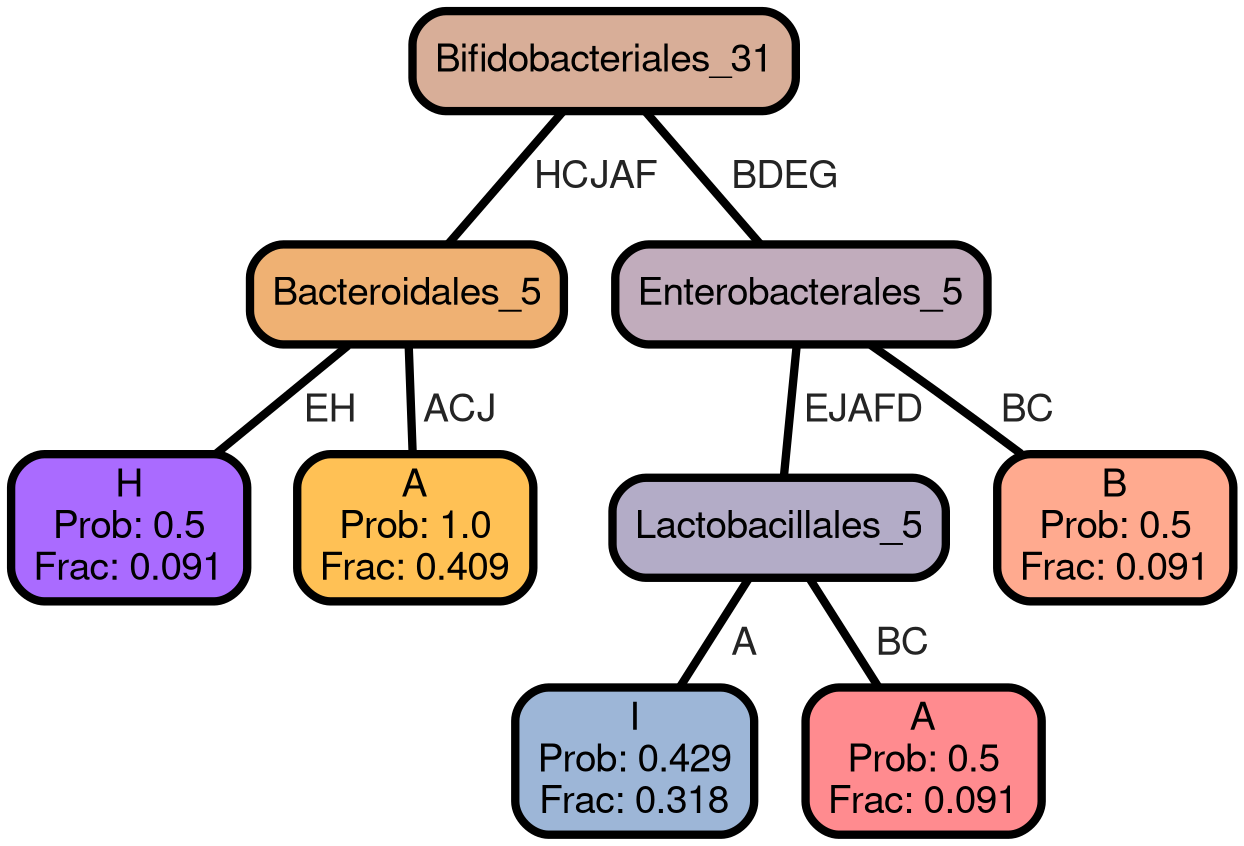

In [9]:
from IPython.display import Image
Image(filename=outdirname+"/"+"Bacteroidales_9.png")

# Generate example hypotheses (`LOMAR` coefficients)

Next, we investigate asymmetric (i.e. with a specified source and target) causal interactions between taxa, using `Hypothesis()` methods.

The `causal_constraint` parameter constrains which time points for source can be considered as inputs when computing source to target influences. If causal_constraint is `None`, there are no restrictions. Otherwise, only sources that are at least `causal_constraint` units of time prior to the target may be considered. Note that negative values are allowed, and may be of use if there is possible imprecision in time measurement in the data.


In [11]:
qnet_orchestrator.load_qnet("example_qnet.pkl.gz",GZIP=True)
hypothesis = Hypothesis(
    quantizer=quantizer,qnet_orchestrator=qnet_orchestrator, detailed_labels=True
)

hypothesis.causal_constraint = -2
hypothesis.no_self_loops = False

hypothesis.get(time_start=10, time_end=20)
hypothesis.to_dot("hypothesis_10_20.dot")
hypothesis.hypotheses.sort_values("src")

100%|███████████████████████████████████████████| 16/16 [00:07<00:00,  2.24it/s]


,src,tgt,time_tgt,lomar,pvalue
54,Actinomycetales,Lactobacillales,18.0,44.078473,0.000000e+00
114,Bacteroidales,Veillonellales-Selenomonadales,18.0,0.002937,3.051737e-220
15,Bacteroidales,Clostridiales,18.0,-0.035250,1.138404e-33
41,Bacteroidales,unclassified_Bacteria,14.0,0.000539,0.000000e+00
82,Bacteroidales,Peptostreptococcales-Tissierellales,10.0,0.420551,0.000000e+00
...,...,...,...,...,...
117,unclassified_Bacteria,Veillonellales-Selenomonadales,14.0,0.339289,0.000000e+00
37,unclassified_Bacteria,Coriobacteriales,18.0,0.166442,0.000000e+00
96,unclassified_Bacteria,Lachnospirales,14.0,6.402486,0.000000e+00
31,unclassified_Bacteria,Bacteroidales,10.0,-6.779463,0.000000e+00


# Forecast microbiome evolution

Next, we forecast abundances from a given initial time point, using the `Forecaster()`.

Note that the `forecast_data()` method uses data in the form of a quantized numpy array (here, the `label_matrix` from above).

In [12]:
# forecast from time SW
SW = 29
#qnet_orchestrator = QnetOrchestrator(quantizer)
#qnet_orchestrator.load_qnet("example_qnet.pkl.gz",GZIP=True)
forecaster = Forecaster(qnet_orchestrator)
# can specify an end week or default to the max end week in the data
forecasted_ = forecaster.forecast_data(label_matrix, start_week=SW).assign(
    source="forecasted"
)

The result is a long-form data frame of relative abundances for each subject. 

In [13]:
DF = forecasted_
SUBJECTS = DF.subject_id.value_counts().index.values
DF

DF_pop = DF.groupby(["variable", "week"]).mean(numeric_only=True).reset_index()
DF_data = data.groupby(["variable", "week"]).mean(numeric_only=True).reset_index()

For comparison, we plot the forecasted vs. actual data (averaged over all subjects):

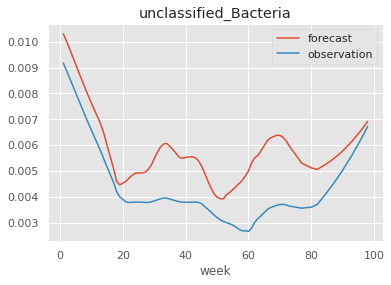

In [14]:
DF_pop = DF.groupby(["variable", "week"]).mean(numeric_only=True).reset_index()
DF_data = data.groupby(["variable", "week"]).mean(numeric_only=True).reset_index()

DF_pop_smooth = qsmooth(
    DF_pop,
    index="week",
    columns="variable",
    normalize=False,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.3,
)

# DF_data_smooth
DF_data_smooth = qsmooth(
    DF_data,
    index="week",
    columns="variable",
    normalize=False,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.3,
)

ax = DF_pop_smooth[biome].plot(label="forecast")
DF_data_smooth[biome].plot(ax=ax, label="observation")
ax.set_title(biome)
ax.legend()

Here is a comparison plot for an individual subject:

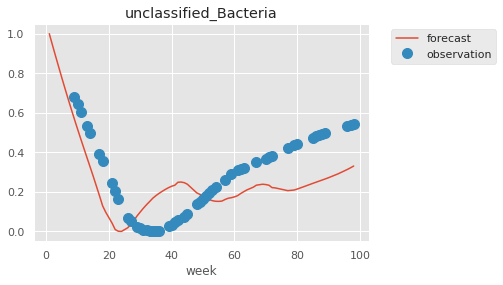

In [15]:
SID = "21"
DF_pop = (
    DF[DF.subject_id == SID]
    .groupby(["variable", "week"])
    .mean(numeric_only=True)
    .reset_index()
)
DF_data = (
    data[DF.subject_id == SID]
    .groupby(["variable", "week"])
    .mean(numeric_only=True)
    .reset_index()
)
DF_pop_smooth = qsmooth(
    DF_pop,
    index="week",
    columns="variable",
    normalize=True,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.4,
)

# DF_data_smooth
DF_data_smooth = qsmooth(
    DF_data,
    index="week",
    columns="variable",
    normalize=True,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.6,
)

var = biome
ax = DF_pop_smooth[var].plot(label="forecast")
DF_data_smooth[var].plot(ax=ax, style="o", ms=10, label="observation")
ax.set_title(biome)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

## Forecast data for a new patient

If we want to forecast the trajectory of a new subject, we just read in their data, quantize, and forecast. 

Here we demonstrate by randomly generating a dummy subject and forecasting from week 29.

,week,variable,value
0,29,unclassified_Bacteria,0.525503
1,29,Lactobacillales,0.998309
2,29,Bacteroidales,0.117522
3,29,Lachnospirales,0.354388
4,29,Bifidobacteriales,0.993561
5,29,Veillonellales-Selenomonadales,0.432952
6,29,Enterobacterales,0.364474
7,29,Peptostreptococcales-Tissierellales,0.904168
8,29,Clostridiales,0.952554
9,29,Erysipelotrichales,0.319629


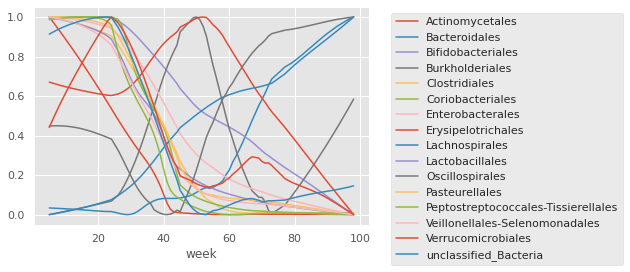

In [16]:
new_subject = pd.DataFrame(
    {
        "week": [SW] * len(TAXA),
        "variable": TAXA,
        "value": np.random.rand(len(TAXA)),
    }
)

new_subject.to_csv("example_data/single_patient_dummy/new_subject.csv", index=None)
new_subject = pd.read_csv("example_data/single_patient_dummy/new_subject.csv")
display(new_subject)

new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id=12345)
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, start_week=29, subject_id=[12345]
)

df_ = qsmooth(
    new_subject_forecasted.drop("subject_id", axis=1),
    index="week",
    columns="variable",
    interpolate=False,
    alpha=0.5,
    lowess_fraction=0.5,
    normalize=True,
)

ax = df_.plot()
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")